In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib as mpl

In [2]:
#Import Data
betes_dat=pd.read_csv('/Users/benkelly/Downloads/diabetes (2).csv')

# Inspection

In [3]:
#Check out data types, dataaframe shape, and nulls
betes_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
#Double check for any null values
betes_dat.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
betes_dat.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


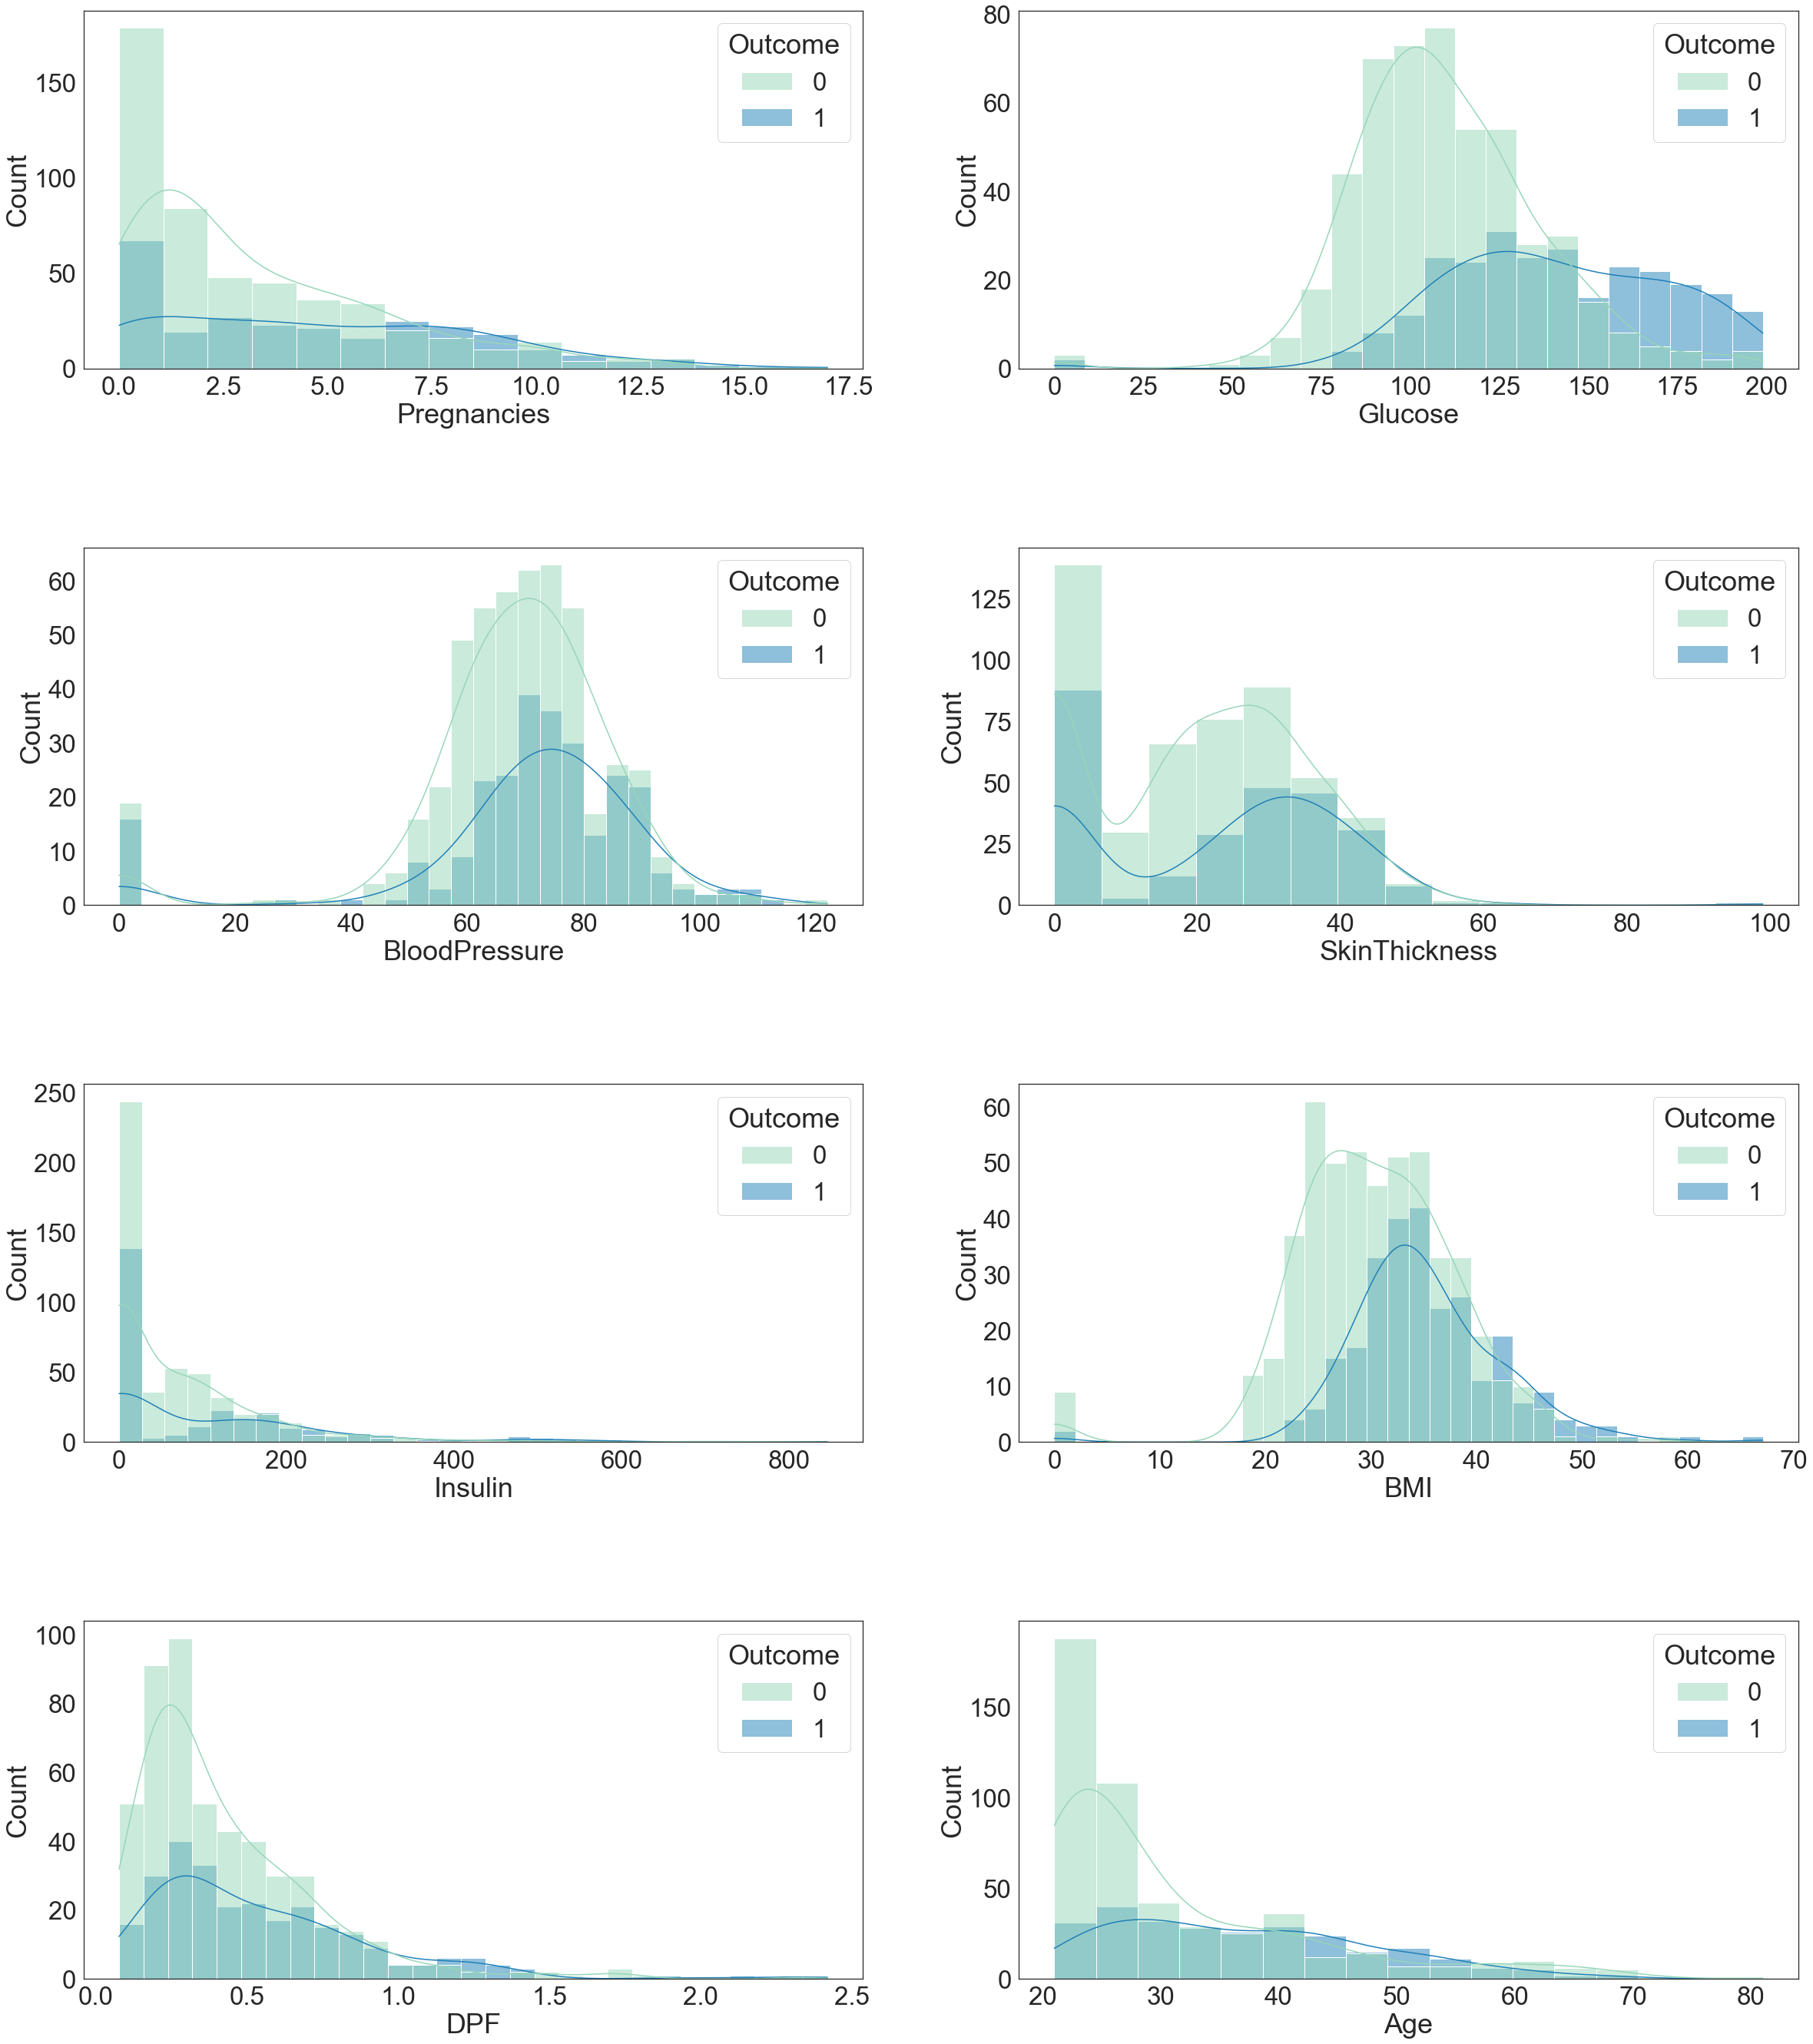

In [6]:
#Histograms
betes_dat.rename(columns={'DiabetesPedigreeFunction':'DPF'}, inplace=True)

feature_names = [cname for cname in betes_dat.loc[:,:'Age'].columns]
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=betes_dat, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

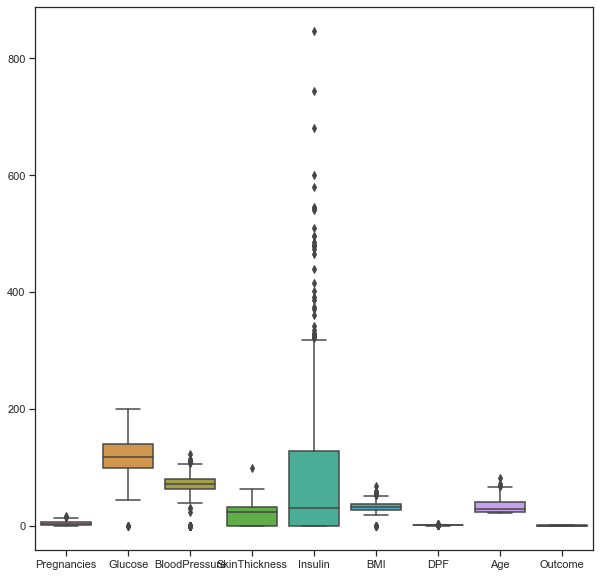

In [7]:
#BoxPlot to show outliers 
sns.set_theme(style="ticks", palette="YlGnBu")
fig , ax = plt.subplots(figsize = (10,10))
sns.boxplot(data = betes_dat, ax = ax)
sns.set(font_scale = 1)

Generally normal distributions. Pregnancies, DPF, and Age are closer to Poisson. Generally positively skewed

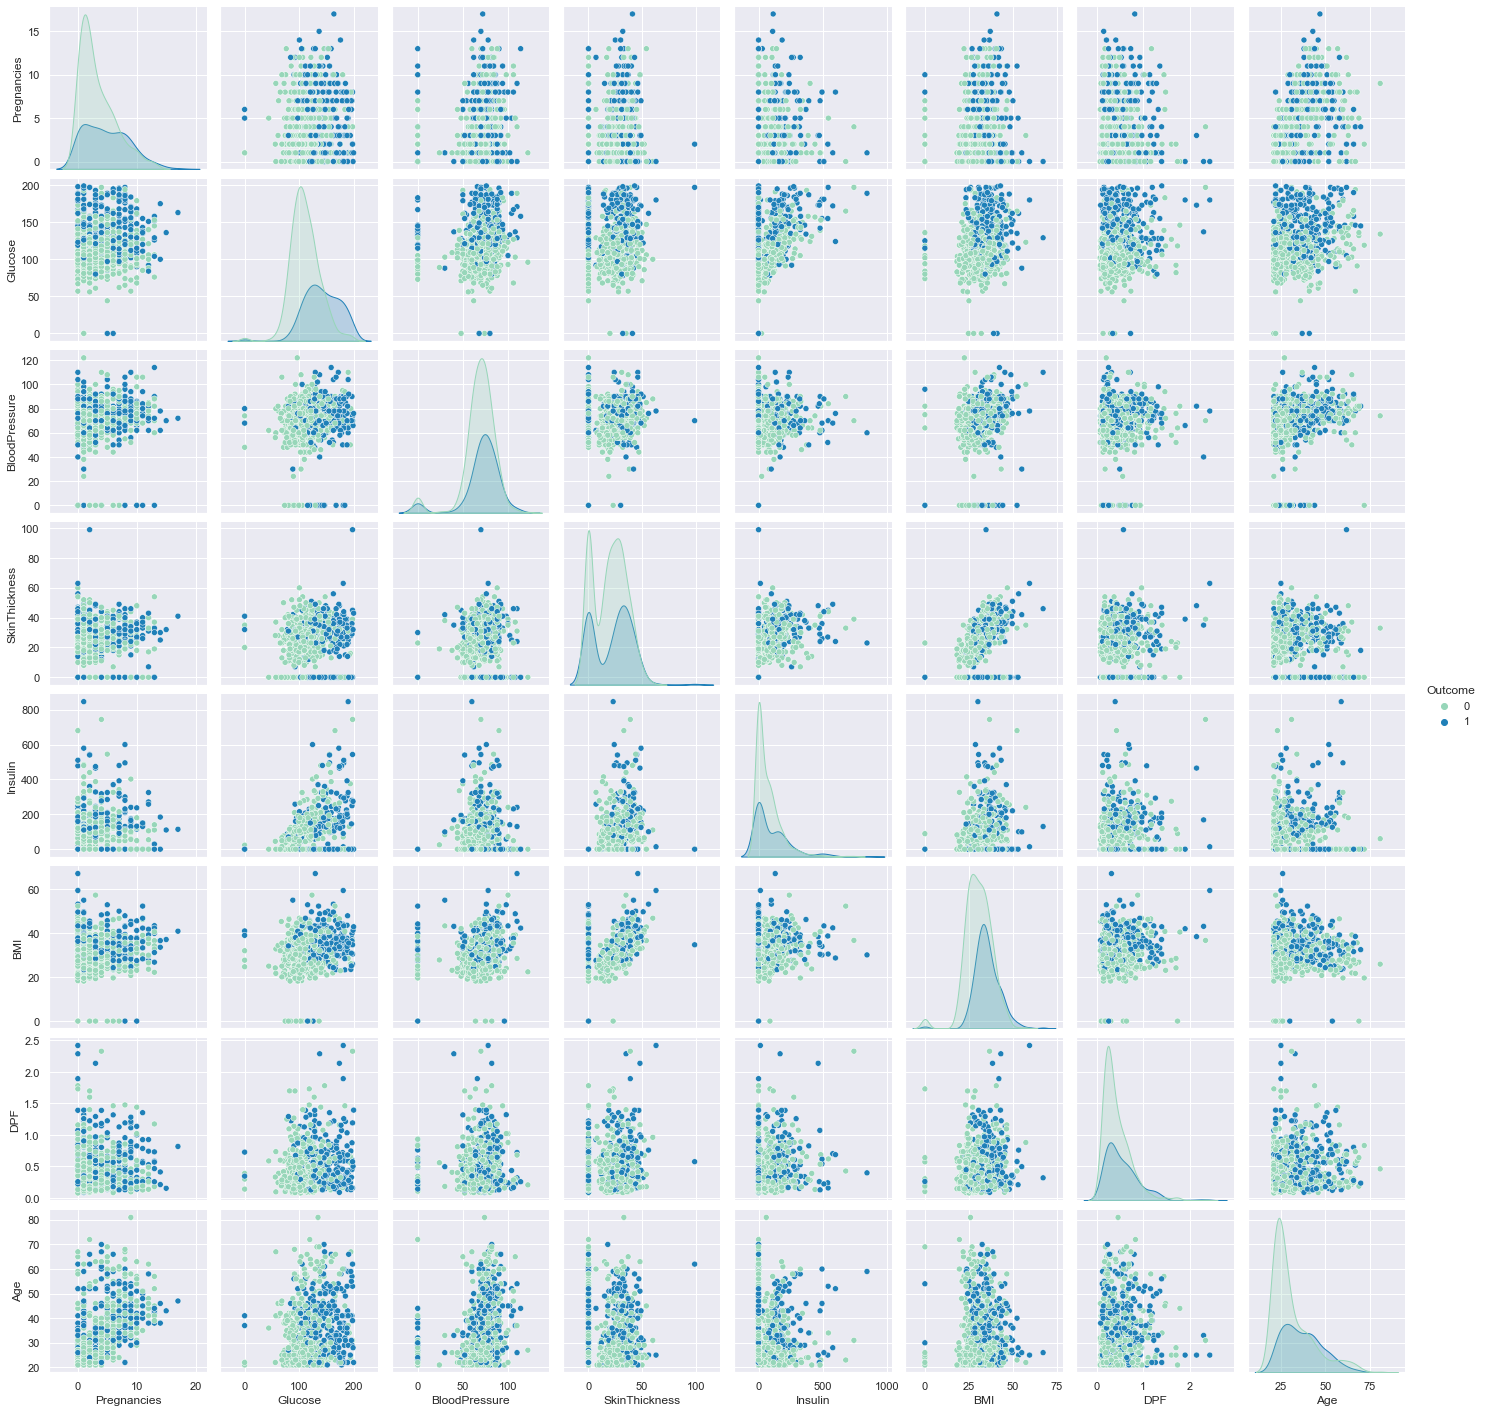

In [8]:
# Scatter Plots
sns.pairplot(betes_dat, hue="Outcome", palette="YlGnBu")

### Is this data Tidy?
EVERY COLUMN IS A VARIABLE: Yes, different biological measures.
EVERY ROW IS AN OBSERVATION: Yes, each row is one individual in the dataset.
EVERY CELL IS A VALUE: Yes, measure of each measure per individual.

The data is Tidy.

# Cleaning

In [9]:
#Check for columns with values of 0 (not )
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DPF','Age']
total_count = betes_dat['Outcome'].count()

for feature in zero_features:
    zero_count = betes_dat[betes_dat[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, {2}%'.format(feature, zero_count, int(100*zero_count/total_count)))

Pregnancies 0 number of cases 111, 14%
Glucose 0 number of cases 5, 0%
BloodPressure 0 number of cases 35, 4%
SkinThickness 0 number of cases 227, 29%
Insulin 0 number of cases 374, 48%
BMI 0 number of cases 11, 1%
DPF 0 number of cases 0, 0%
Age 0 number of cases 0, 0%


0 pregnancies make sense, but all the other 0's are more suspicious. 
Blood Pressure and BMI should not be 0, that would mean death, so replace with median values.
Based on research skin thickness can not be 0, so I will also replace those with the median.

Test if insulin has any relationship to Outcome (will not be my final hypothesis).Strong relationship to diabetes. Research has found that previously thought levels of 0 insulin may just not have been tested with precise methods. This means 0 Insulin measures aer

In [10]:
df=betes_dat.copy()

In [11]:
#Replace 0's with Nan's
df[['Glucose','BloodPressure','BMI']] = df[['Glucose','BloodPressure','BMI']].replace(0, np.NaN)

In [12]:
# The missing values will be filled with the median values of each variable.

def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [13]:
#Fill Glucose 0's
var='Glucose'
out=median_target(var)
df.loc[(df['Outcome'] == 0 ) & (df[var].isnull()), var] = out.iloc[0][1]
df.loc[(df['Outcome'] == 1 ) & (df[var].isnull()), var] = out.iloc[1][1]

#Fill BP 0's
var='BloodPressure'
out=median_target(var)
df.loc[(df['Outcome'] == 0 ) & (df[var].isnull()), var] = out.iloc[0][1]
df.loc[(df['Outcome'] == 1 ) & (df[var].isnull()), var] = out.iloc[1][1]

#Fill BMI 0's
var='BMI'
out=median_target(var)
df.loc[(df['Outcome'] == 0 ) & (df[var].isnull()), var] = out.iloc[0][1]
df.loc[(df['Outcome'] == 1 ) & (df[var].isnull()), var] = out.iloc[1][1]

In [14]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.389323,20.536458,79.799479,32.434635,0.471876,33.240885,0.348958
std,3.369578,30.464161,12.106039,15.952218,115.244002,6.880498,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,0.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,0.000000,0.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


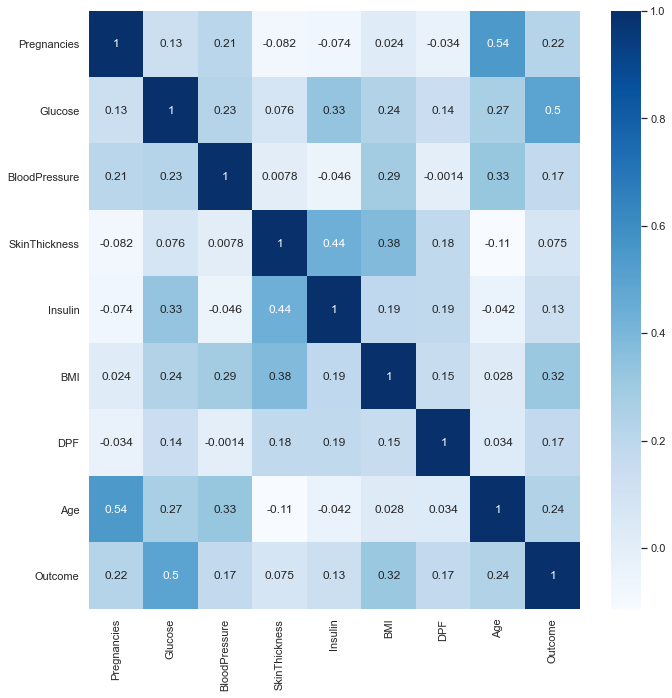

In [15]:
figsns=plt.figure(3,figsize=(11,11))

sns.heatmap(df.corr(),annot=True,cmap='Blues')

plt.show()

# Binning

In [16]:
#Age binning following (Petry, 2002)
def age_to_age_bin(row):
    if 21 <= row["Age"] < 30:
        return "1-Young Adult"
    elif 30 <= row["Age"] < 65:
        return "2-Middle Age"
    else:
        return "3-Older Adult"


# Binning based on (Health Canada, 2010)
def bmi_to_bmi_bin(row):
    if row["BMI"] < 18.5:
        return "1-Underweight"
    elif row["BMI"] < 24.9:
        return "2-Normal"
    elif row["BMI"] < 29.9:
        return "3-Overweight"
    elif row["BMI"] >= 29.9:
        return "4-Obese"
    else:
        return None

In [17]:
#Apply binning
df["AgeBins"] = df.apply(age_to_age_bin, axis=1)
#df["BloodPressureGroup"] = df.apply(blood_pressure_to_blood_pressure_group, axis=1) Can bin BP for later analysis
df["BMIBins"] = df.apply(bmi_to_bmi_bin, axis=1)

In [18]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.389323,20.536458,79.799479,32.434635,0.471876,33.240885,0.348958
std,3.369578,30.464161,12.106039,15.952218,115.244002,6.880498,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,0.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,0.000000,0.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### Create Dummy Variables for Shapiro and Linear Regression Later

In [19]:
df['AgeDums'] = df['AgeBins'].map({'1-Young Adult':1,  '2-Middle Age':2,'3-Older Adult':3})
df['BMIDums'] = df['BMIBins'].map({'1-Underweight':1, '2-Normal':2,'3-Overweight':3,'4-Obese':4})

[(20.0, 140.0)]

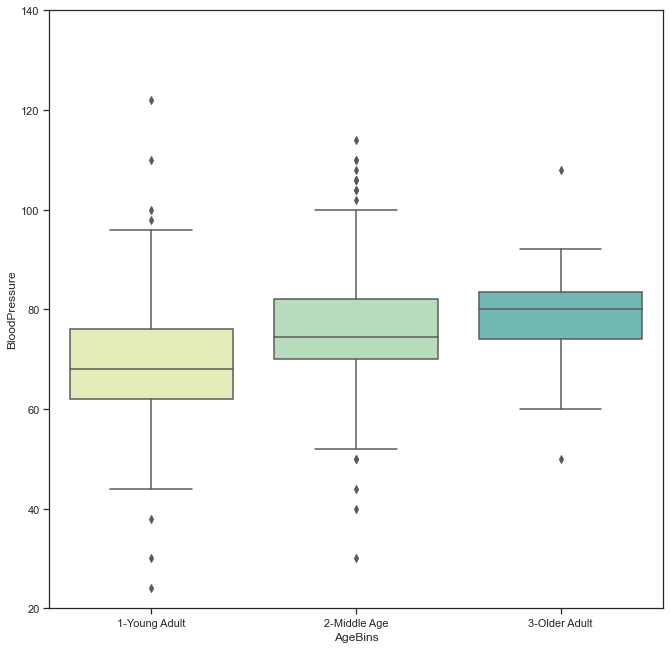

In [20]:
# Boxplot of Age bins vs Blood Pressure
sns.set_theme(style="ticks", palette="YlGnBu")
figsns=plt.figure(3,figsize=(11,11))
ax = sns.boxplot(x="AgeBins", y="BloodPressure", data=df, order=['1-Young Adult','2-Middle Age','3-Older Adult'])

# Limit y-axis
ax.set(ylim=(20, 140))

[(20.0, 140.0)]

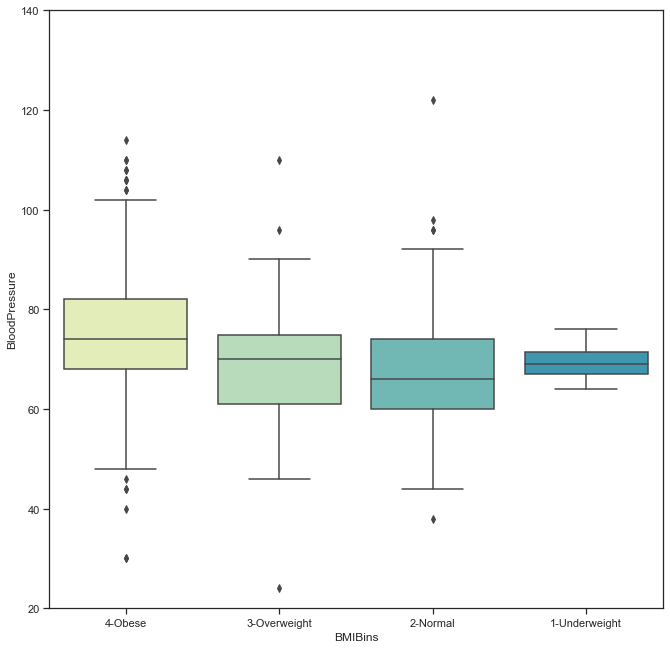

In [21]:
# Boxplot of BMI bins vs Blood Pressure
figsns=plt.figure(3,figsize=(11,11))
ax = sns.boxplot(x="BMIBins", y="BloodPressure", data=df)

# Limit y-axis
ax.set(ylim=(20, 140))

In [51]:
df['AgeBins'].value_counts()

1-Young Adult    396
2-Middle Age     356
3-Older Adult     16
Name: AgeBins, dtype: int64

In [52]:
df['BMIBins'].value_counts()

4-Obese          488
3-Overweight     175
2-Normal         101
1-Underweight      4
Name: BMIBins, dtype: int64

Older adults and underweight individuals are relatively underrepresented in the data.

# Assumption Testing

### Shapiro-Wilks

In [22]:
#Shapiro-Wilks Test of Normality
stat, pvalue = stats.shapiro(df['Pregnancies'])
print('Pregnancies - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['Glucose'])
print('Glucose - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['BloodPressure'])
print('BloodPressure - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['SkinThickness'])
print('SkinThickness - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['Insulin'])
print('Insulin - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['BMI'])
print('BMI - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['DPF'])
print('DPF - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['Age'])
print('Age - Test Stat: ', stat,' p-value:',pvalue)

Pregnancies - Test Stat:  0.9042782783508301  p-value: 1.6080885881590613e-21
Glucose - Test Stat:  0.9697533249855042  p-value: 1.6375369810139873e-11
BloodPressure - Test Stat:  0.9882556200027466  p-value: 7.92563059803797e-06
SkinThickness - Test Stat:  0.90462726354599  p-value: 1.75157635361056e-21
Insulin - Test Stat:  0.7220207452774048  p-value: 7.915248149269491e-34
BMI - Test Stat:  0.9791935682296753  p-value: 5.41224309813515e-09
DPF - Test Stat:  0.8365186452865601  p-value: 2.477696547502535e-27
Age - Test Stat:  0.8747662305831909  p-value: 2.401946561183188e-24


None are normal, but fine considering sample size.

In [23]:
#Dummy Shapiros
stat, pvalue = stats.shapiro(df['AgeDums'])
print('AgeBins - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['BMIDums'])
print('BMIBins - Test Stat: ', stat,' p-value:',pvalue)

AgeBins - Test Stat:  0.6905151605606079  p-value: 3.1340381219460363e-35
BMIBins - Test Stat:  0.6831753253936768  p-value: 1.5345312497563895e-35


New dummy bins are still non-normal.

### Levene's Tests

In [24]:
#BloodPressure and Age
from bioinfokit.analys import stat
res = stat()
res.levene(df=df, res_var='BloodPressure', xfac_var='Age')
res.levene_summary

,Parameter,Value
0,Test statistics (W),0.9562
1,Degrees of freedom (Df),51.0000
2,p value,0.5625


In [25]:
#BloodPressure and Age Bins
from bioinfokit.analys import stat
res = stat()
res.levene(df=df, res_var='BloodPressure', xfac_var='AgeBins')
res.levene_summary

,Parameter,Value
0,Test statistics (W),0.8485
1,Degrees of freedom (Df),2.0000
2,p value,0.4285


In [26]:
#BloodPressure and BMI
res = stat()
res.levene(df=df, res_var='BloodPressure', xfac_var='BMI')
res.levene_summary

,Parameter,Value
0,Test statistics (W),1.1201
1,Degrees of freedom (Df),246.0000
2,p value,0.1455


In [27]:
#BloodPressure and BMI Bins
res = stat()
res.levene(df=df, res_var='BloodPressure', xfac_var='BMIBins')
res.levene_summary

,Parameter,Value
0,Test statistics (W),0.9492
1,Degrees of freedom (Df),3.0000
2,p value,0.4163


In [28]:
#Age and BMI
res = stat()
res.levene(df=df, res_var='Age', xfac_var='BMI')
res.levene_summary

,Parameter,Value
0,Test statistics (W),0.6771
1,Degrees of freedom (Df),246.0000
2,p value,0.9997


In [29]:
#Age and BMI Bins
#Can not find variance between two categorical variables.
#res = stat()
#res.levene(df=df, res_var='AgeBins', xfac_var='BMIBins')
#res.levene_summary

All variables have equal variance as we accept the null hypothesis in all Levene's tests.

# T-tests

In [77]:
tStat, pValue = stats.ttest_ind( df['Age'],df['BloodPressure'])
print("Age X BP P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

tStat, pValue = stats.ttest_ind(df['BMI'],df['BloodPressure'])
print("BMI X BP P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

tStat, pValue = stats.ttest_ind(df['BMI'],df['Age'])
print("BMI X Age P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

Age X BP P-Value:0.0 T-Statistic:-64.28059615368309
BMI X BP P-Value:0.0 T-Statistic:-79.51742692680928
BMI X Age P-Value:0.10123714230314101 T-Statistic:-1.6398704229939216


Both proposed predictor variables correlate with Blood pressure, but not with eachother at a significant p-value of 0.05. 0.0 is significant as the code does not have the capacity present the many digits required.

In [75]:
#Test of p-value limits
tStat, pValue = stats.ttest_ind( df['Glucose'],df['BloodPressure'])
print("Glucose X BP TEST P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

Glucose X BP TEST P-Value:2.0053059110027688e-254 T-Statistic:41.6669757518738


In [78]:
#T-statistics with dummy variables
tStat, pValue = stats.ttest_ind( df['AgeDums'],df['BloodPressure'])
print("Age X BP P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

tStat, pValue = stats.ttest_ind(df['BMIDums'],df['BloodPressure'])
print("BMI X BP P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

tStat, pValue = stats.ttest_ind(df['BMIDums'],df['AgeDums'])
print("BMI X Age P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

Age X BP P-Value:0.0 T-Statistic:-162.1045522407006
BMI X BP P-Value:0.0 T-Statistic:-157.42205456754684
BMI X Age P-Value:0.0 T-Statistic:60.229138692097024


All means are now significantly different. 

# ANOVA's

### One-Way ANOVA's

In [32]:
#Age X BP ONE-WAY ANOVA
model = ols('BloodPressure ~ AgeBins', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
AgeBins,9768.287006,2.0,36.402559,7.912213e-16
Residual,102640.305442,765.0,NaN,NaN


In [33]:
#TukeyHSD with Bonferoni Correction
pair_t = model.t_test_pairwise('AgeBins')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
2-Middle Age-1-Young Adult,6.928470,0.845989,8.189790,1.094865e-15,5.267735,8.589205,3.284594e-15,True
3-Older Adult-1-Young Adult,10.286616,2.953720,3.482597,5.247783e-04,4.488258,16.084974,1.049281e-03,True
3-Older Adult-2-Middle Age,3.358146,2.960157,1.134449,2.569617e-01,-2.452849,9.169141,2.569617e-01,False


BloodPressure is significantly different between Age bins, namely from Young adults to the other bins, but not between Older and Middle Age adults.

In [34]:
#BMI X BP ONE-WAY ANOVA
model = ols('BloodPressure ~ BMIBins', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
BMIBins,5594.609505,3.0,13.338708,1.711472e-08
Residual,106813.982942,764.0,NaN,NaN


In [35]:
#TukeyHSD with Bonferoni Correction
pair_t = model.t_test_pairwise('BMIBins')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
2-Normal-1-Underweight,-1.539604,6.027974,-0.255410,7.984753e-01,-13.372962,10.293754,0.959388,False
3-Overweight-1-Underweight,-0.122857,5.979225,-0.020547,9.836121e-01,-11.860517,11.614803,0.983612,False
4-Obese-1-Underweight,4.909836,5.936220,0.827098,4.084398e-01,-6.743403,16.563075,0.807871,False
3-Overweight-2-Normal,1.416747,1.477550,0.958849,3.379384e-01,-1.483793,4.317287,0.807871,False
4-Obese-2-Normal,6.449440,1.292571,4.989621,7.495704e-07,3.912028,8.986853,0.000004,True
4-Obese-3-Overweight,5.032693,1.041826,4.830646,1.644747e-06,2.987512,7.077875,0.000008,True


Significant different in blood pressure between BMI's, but mostly driven by large difference between Obese folks and overweight and normal ranged people. 

### Two-Way ANOVA

In [53]:
#BMI+Age X BloodPressure TWO-WAY ANOVA
model = ols('BloodPressure ~ C(AgeBins) + C(BMIBins) + C(AgeBins):C(BMIBins)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(AgeBins),2.713208e-10,2.0,1.059562e-12,1.000000e+00
C(BMIBins),5.594610e+03,3.0,1.456538e+01,3.125602e-09
C(AgeBins):C(BMIBins),9.763886e+03,6.0,1.270997e+01,1.061197e-13
Residual,9.705010e+04,758.0,NaN,NaN


In [38]:
#TukeyHSD with Bonferoni Correction Age
pair_t = model.t_test_pairwise('C(AgeBins)')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
2-Middle Age-1-Young Adult,5.063630,0.782806,6.468562,1.773510e-10,3.526904,6.600355,5.320529e-10,True
3-Older Adult-1-Young Adult,5.765852,2.348251,2.455381,1.429703e-02,1.156004,10.375700,2.838966e-02,True
3-Older Adult-2-Middle Age,0.702222,2.373746,0.295829,7.674420e-01,-3.957675,5.362119,7.674420e-01,False


In [37]:
#TukeyHSD with Bonferoni Correction BMI
pair_t = model.t_test_pairwise('C(BMIBins)')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
2-Normal-1-Underweight,-3.579365,5.834458,-0.613487,0.539738,-15.032981,7.874251,0.937461,False
3-Overweight-1-Underweight,-3.898936,5.776736,-0.674938,0.499921,-15.239238,7.441365,0.937461,False
4-Obese-1-Underweight,1.614894,5.705562,0.283038,0.777225,-9.585686,12.815474,0.950371,False
3-Overweight-2-Normal,-0.319571,1.842379,-0.173456,0.862340,-3.936343,3.297201,0.950371,False
4-Obese-2-Normal,5.194259,1.605341,3.235611,0.001267,2.042816,8.345701,0.006317,True
4-Obese-3-Overweight,5.513830,1.380904,3.992913,0.000072,2.802979,8.224680,0.000430,True


Second Two-Way ANOVA method below. (Above method was not condusive to applying Tukey to the interaction).

In [54]:
import warnings
warnings.filterwarnings("ignore")
res=stat()
res.anova_stat(df=df, res_var='BloodPressure',anova_model='BloodPressure ~ C(AgeBins) + C(BMIBins) + C(AgeBins):C(BMIBins)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(AgeBins),2.0,2.713208e-10,1.356604e-10,1.059562e-12,1.000000e+00
C(BMIBins),3.0,5.594610e+03,1.864870e+03,1.456538e+01,3.125602e-09
C(AgeBins):C(BMIBins),6.0,9.763886e+03,1.627314e+03,1.270997e+01,1.061197e-13
Residual,758.0,9.705010e+04,1.280344e+02,NaN,NaN


In [39]:
#TukeyHSD with Bonferoni Correction -Age in Two-Way
res=stat()
res.tukey_hsd(df=df, res_var='BloodPressure', xfac_var='AgeBins',anova_model='BloodPressure ~ C(AgeBins) + C(BMIBins) + C(AgeBins):C(BMIBins)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,2-Middle Age,1-Young Adult,6.928470,4.987727,8.869213,11.856394,0.001000
1,2-Middle Age,3-Older Adult,3.358146,-3.432611,10.148904,1.642346,0.478468
2,1-Young Adult,3-Older Adult,10.286616,3.510626,17.062606,5.041771,0.001126


In [40]:
#TukeyHSD with Bonferoni Correction -BMI in Two-Way
res=stat()
res.tukey_hsd(df=df, res_var='BloodPressure', xfac_var='BMIBins',anova_model='BloodPressure ~ C(AgeBins) + C(BMIBins) + C(AgeBins):C(BMIBins)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,4-Obese,3-Overweight,5.032693,2.465667,7.599719,7.138784,0.001000
1,4-Obese,2-Normal,6.449440,3.264586,9.634294,7.373719,0.001000
2,4-Obese,1-Underweight,4.909836,-9.716822,19.536494,1.222295,0.800152
3,3-Overweight,2-Normal,1.416747,-2.223889,5.057383,1.416997,0.722921
4,3-Overweight,1-Underweight,0.122857,-14.609762,14.855476,0.030365,0.900000
5,2-Normal,1-Underweight,1.539604,-13.313131,16.392339,0.377448,0.900000


In [64]:
#Two-way Interaction post-hoc
res=stat()
res.tukey_hsd(df=df, res_var='BloodPressure', xfac_var=['AgeBins','BMIBins'],anova_model='BloodPressure ~ C(AgeBins) + C(BMIBins) + C(AgeBins):C(BMIBins)')
res.tukey_summary.dropna().head(67) #NA's only occur for Underweight groups with no values in certain age groupsa


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(2-Middle Age, 4-Obese)","(2-Middle Age, 3-Overweight)",3.774194,-1.096463,8.644852,3.592636,0.316635
1,"(2-Middle Age, 4-Obese)","(2-Middle Age, 2-Normal)",4.861224,-1.842047,11.564496,3.362291,0.426658
2,"(2-Middle Age, 4-Obese)","(2-Middle Age, 1-Underweight)",0.000000,-inf,inf,0.000000,0.900000
3,"(2-Middle Age, 4-Obese)","(1-Young Adult, 4-Obese)",6.060617,2.673513,9.447721,8.295924,0.001000
4,"(2-Middle Age, 4-Obese)","(1-Young Adult, 3-Overweight)",11.574446,7.073770,16.075122,11.923368,0.001000
5,"(2-Middle Age, 4-Obese)","(1-Young Adult, 2-Normal)",11.254875,6.014687,16.495064,9.957957,0.001000
6,"(2-Middle Age, 4-Obese)","(1-Young Adult, 1-Underweight)",7.675510,-11.023194,26.374215,1.903147,0.900000
7,"(2-Middle Age, 4-Obese)","(3-Older Adult, 4-Obese)",9.324490,-4.003268,22.652248,3.243728,0.483857
8,"(2-Middle Age, 4-Obese)","(3-Older Adult, 3-Overweight)",2.024490,-14.733690,18.782669,0.560100,0.900000
9,"(2-Middle Age, 4-Obese)","(3-Older Adult, 2-Normal)",17.175510,-4.372494,38.723514,3.695550,0.274316


#### Interaction Plot

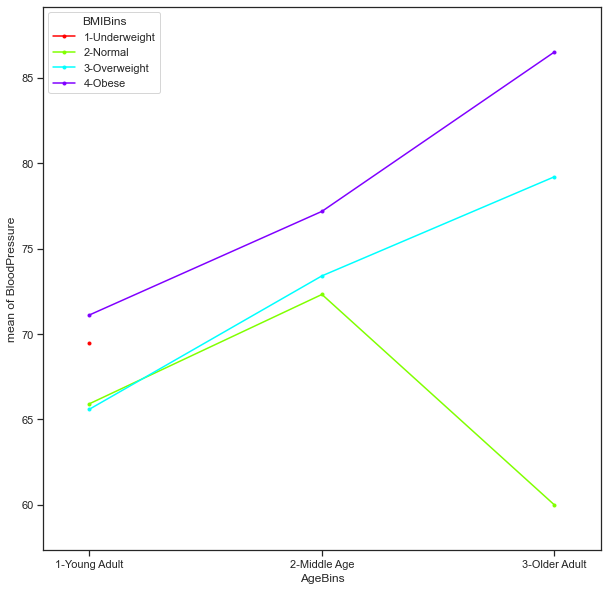

In [79]:
#Interaction Plot between Age and BMI as predictors of Blood Pressure
with mpl.rc_context():
    mpl.rc("figure", figsize=(10,10))
    interaction_plot(x=df['AgeBins'], trace=df['BMIBins'], response=df['BloodPressure'])

# Linear Regression

In [67]:
#USING DUMMY VALUES
X = df[['AgeDums','BMIDums']]
y = df['BloodPressure']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(regressor.intercept_)
print(regressor.coef_)

#making predictions
y_pred = regressor.predict(X_test)
r2 = regressor.score(X, y)

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared:', r2)

53.5404848245179
[5.94461325 2.8755032 ]
Mean Absolute Error: 8.777682676115711
Mean Squared Error: 131.44183521973116
Root Mean Squared Error: 11.464808555738346
R-squared: 0.11964006559335005


In [68]:
#View coefficients better
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
AgeDums,5.944613
BMIDums,2.875503


In [48]:
#Making predictions
preds = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
preds.head()

,Actual,Predicted
661,76.0,70.987111
122,74.0,70.987111
113,62.0,70.987111
14,72.0,74.056221
529,65.0,71.180718


In [69]:
#USING ORIGINAL VALUES
X = df[['Age','BMI']]
y = df['BloodPressure']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(regressor.intercept_)
print(regressor.coef_)

#making predictions
y_pred = regressor.predict(X_test)
r2 = regressor.score(X, y)

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared:', r2)

45.893297826162154
[0.31737325 0.49293738]
Mean Absolute Error: 8.560188259722757
Mean Squared Error: 127.39256897124068
Root Mean Squared Error: 11.28683166221773
R-squared: 0.18259175734127708


In [70]:
#Better view coefficients
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Age,0.317373
BMI,0.492937


In [50]:
#Making predictions
preds = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
preds.head()

,Actual,Predicted
661,76.0,74.022523
122,74.0,69.755579
113,62.0,70.587500
14,72.0,74.797118
529,65.0,67.858128
